In [1]:
# Python 2
import numpy as np
import pandas as pd
from __future__ import print_function
np.set_printoptions(threshold=np.nan, linewidth=np.nan)
%matplotlib inline

In [2]:
import xmltodict
from collections import Counter
from os import listdir
from os.path import join
def parse_annotations():
    """
    Parses annotation xml files of PASCAL VOC 2012.
    Note that a few annotations contains non-integer bounding box and requires manual fix.
    Returns:
        df: Pandas dataframe of image name, label, and bounding box size ratio, of images with only one annotated object
        obj_count: collections.Counter instance for number of annotated objects in all images
    """
    annot_dir = '../pascal12/Annotations'
    single = list()  # use images with single annotated object to focus on classification
    obj_counter = np.zeros(100, dtype=np.uint32)  # #_of_annotated_obj
    filenames = listdir(annot_dir)
    file_count = len(filenames)
    for i in range(0, file_count):
        with open(join(annot_dir, filenames[i]), mode='r') as h:
            a = xmltodict.parse(h.read())['annotation']
            if isinstance(a['object'], list):  # contains more than one annotated object
                obj_counter[len(a['object'])] += 1
            else:
                obj_counter[1] += 1
                b = a['object']['bndbox']
                try:
                    obj_size = (int(b['xmax']) - int(b['xmin'])) * (int(b['ymax']) - int(b['ymin']))
                    img_size = int(a['size']['width']) * int(a['size']['height'])
                except:
                    raise Exception('Error parsing {}'.format(filenames[i]))
                obj_size_ratio = float(obj_size) / img_size
                single.append((a['filename'], a['object']['name'], obj_size_ratio))
            progress = int(float(i) / file_count * 1000) / 10.0
            print('{}: {}%'.format(filenames[i], progress), end='\r')
    df = pd.DataFrame(single, columns=['img', 'label', 'size_ratio'])
    df['label'] = df['label'].astype('category')
    counter_index = np.nonzero(obj_counter)[0]
    obj_count = dict(zip(counter_index, obj_counter[counter_index]))
    return df, obj_count

In [3]:
import pickle
from os.path import isfile
def lazy_parse_annotations():
    cache = 'annotations.pickle'
    if isfile(cache):
        with open(cache, mode='rb') as h:
            return pickle.load(h)
    else:
        df, obj_count = parse_annotations()
        with open(cache, mode='wb') as h:
            pickle.dump((df, obj_count), h)
        return df, obj_count

In [4]:
df, obj_count = lazy_parse_annotations()

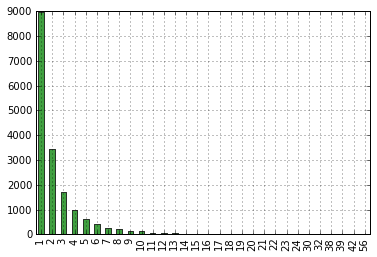

In [5]:
pd.Series(obj_count).plot(kind='bar', color='green', alpha=0.75, grid=True)#.get_figure().savefig('1.pdf')

In [6]:
# subsample 850 images from all "person" images due to unbalanced dataset
import random
df_person = df[df['label'] == 'person']
df_no_person = df.drop(df_person.index)
person_sample = df.ix[random.sample(list(df_person.index), 850)]
df = pd.concat([df_no_person, person_sample], ignore_index=True)

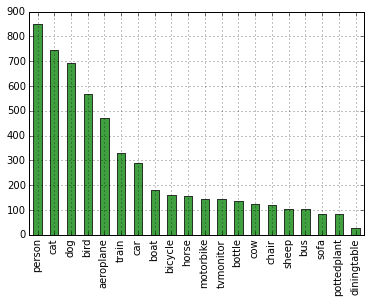

In [7]:
df['label'].value_counts().plot(kind='bar', color='green', alpha=0.75, grid=True)#.get_figure().savefig('2.pdf')

In [8]:
# split the dataset into 3:1 train/test subset
n = len(df)
split = ['test']*int(n/4) + ['train']*(n-int(n/4))
random.shuffle(split)
df['split'] = split
df['split'] = df['split'].astype('category')

In [9]:
with open('hex.pickle', mode='rb') as h:
    hex_data = pickle.load(h)
hex_data.keys()

['H_t', 'H', 'HEX_sparse', 'HEX_dense', 'id_name', 'state_space', 'name_id']

In [10]:
def build_pseudo_labels(hex_data):
    """
    Finds all legal ancestor states of leaf node states in the HEX graph.
    Returns:
        id_pseudo_labels: list<id, list<tuple<id>>>
    """
    state_space = hex_data['state_space']
    n = len(hex_data['id_name'])  # number of concepts
    H_ts = hex_data['H_t'] + np.eye(n, dtype=np.bool)
    id_pseudo_labels = list()
    for i in range(0, n):
        active_ances = list()
        ances_id = np.nonzero(H_ts[:, i])[0]
        for s in set(map(tuple, state_space[:, ances_id])):
            aas = filter(lambda x: x[1], zip(ances_id, s))  # aas for active ancestor state
            if aas:  # ancestors may be all false
                active_ances.append(zip(*aas)[0])
        id_pseudo_labels.append(active_ances)
    return id_pseudo_labels

In [11]:
name_id = hex_data['name_id']
id_pseudo_labels = build_pseudo_labels(hex_data)
df['pseudo_label'] = [random.sample(id_pseudo_labels[name_id[x]], 1)[0] for x in df['label']]

In [12]:
with open('df.pickle', mode='wb') as h:
    pickle.dump(df, h)

In [13]:
df.head()

,img,label,size_ratio,split,pseudo_label
0,2009_001061.jpg,motorbike,0.995339,train,"(13,)"
1,2011_002107.jpg,motorbike,0.947467,train,"(0, 13)"
2,2008_005436.jpg,dog,0.606795,test,"(3,)"
3,2009_002712.jpg,train,0.468864,test,"(16,)"
4,2008_004771.jpg,aeroplane,0.141604,train,"(13, 16)"
